In [20]:
# -*- coding: utf-8 -*-
import h5py
import os
import pickle
import numpy as np
import pandas as pd
import argparse
from wang_args import WangClassifier

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.metrics.functional.classification import auroc, stat_scores
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt


In [21]:
args = argparse.Namespace(mri_sequences='TBAKDEF', data_sequences='TBAKDEF', valid_dir='tbakd3_npy/uint8/5folds/4/train_bal', eval_batch_size=1)
f4 = np.vectorize(lambda x: f'{x:.4f}')
ckpt = '/net/scratch/hanliu/radiology/prostatex/results/wang-fold-bal/z4ktwfw9/checkpoints/epoch=102-valid_acc=0.81.ckpt' # splendid-night-1029
model = WangClassifier.load_from_checkpoint(ckpt, **vars(args))
_ = model.eval()

In [22]:
def gradcam(model, batch, iconv=2):

    model.eval()
    fmaps = []
    grads = []

    def forward_hook(self, input, output):
        fmaps.append(output)

    def backward_hook(self, grad_in, grad_out):
        grads.append(grad_out[0].detach())

    for s in range(model.num_sequences):
        model.conv[s][iconv].layer[-1].register_forward_hook(forward_hook)
        model.conv[s][iconv].layer[-1].register_backward_hook(backward_hook)
    
    x, y = batch
    x = x[:, model.mri_index]
    logits = model(x)
    loss = model.criterion(logits, y.float())
    loss.backward()

    cams = []
    for s in range(model.num_sequences):
        fm, gr = fmaps[s].squeeze().detach(), grads[s].squeeze().detach()
        cam = torch.zeros(fm.shape[1:]).detach()
        weights = gr.mean(axis=[1, 2])
        for i, w in enumerate(weights):
            cam += w * fm[i, :, :]	
        cam = torch.clamp(cam, min=0)
        cam = cam / cam.max() if cam.max() else cam
        cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=batch[0].shape[2:], mode='bilinear')
        cams.append(cam.squeeze())

    return cams

In [75]:
batch = list(iter(model.valid_dataloader()))[196]
cams = gradcam(model, batch, iconv=3)
heatmaps = [255 * cam for cam in cams]

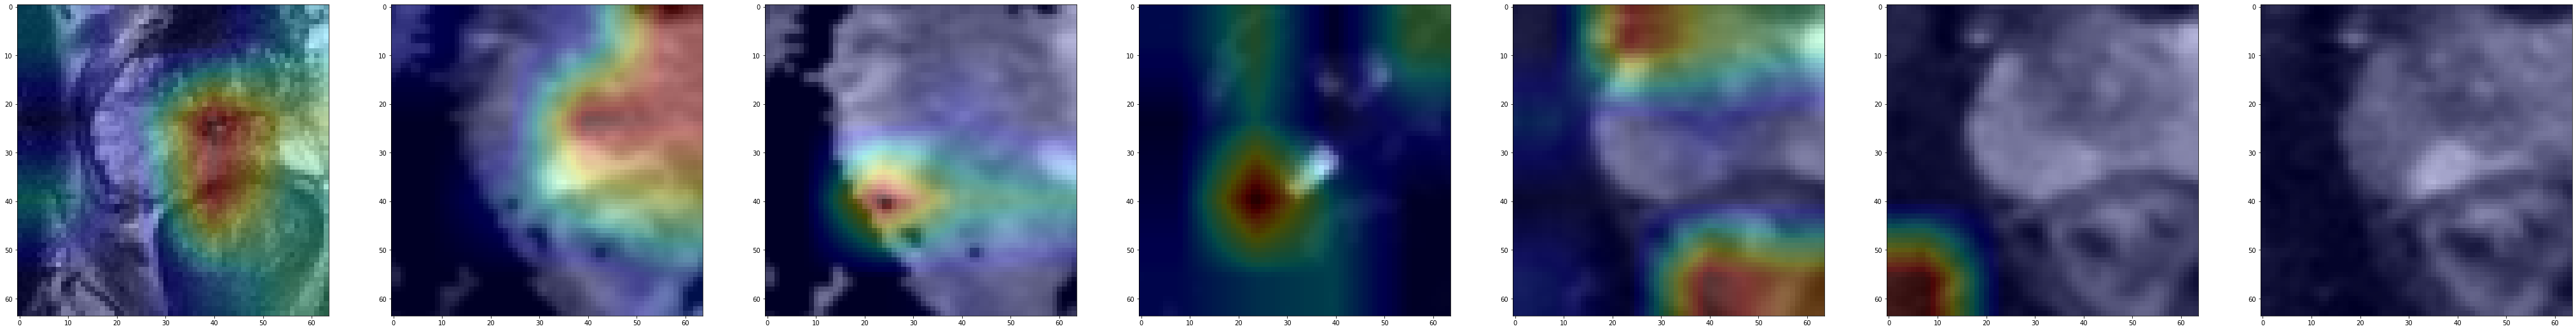

In [77]:
fig, ax = plt.subplots(1, model.num_sequences, figsize=(72, 72))
for i in range(model.num_sequences):
    ax[i].imshow(batch[0].squeeze()[i], cmap='gray')
    ax[i].imshow(heatmaps[i], cmap='jet', alpha=0.3)